In [13]:
import random
import pickle

import numpy as np
import pandas as pd
from nltk.tokenize import RegexpTokenizer

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import RMSprop

In [14]:
text4000 = pd.read_csv(".//Data/4000/4000-stories-VAD.csv")

In [15]:
text4000.head(1)

,url,length,title,text_no,author,story,valence,arousal,dominance,text_id,...,290,291,292,293,294,295,296,297,298,299
0,https://americanliterature.com/author/eleanor-...,15044,"Peace on Earth, Good-Will to Dogs",0,Eleanor Hallowell Abbott,"PART I\n\nIf you don't like Christmas stories,...",0.592896,0.397839,0.569567,0_eleanor-hallowell-abbott-peace-on-earth-good...,...,3.793141,3.837345,3.778354,-0.815515,-0.72044,-10.738245,-8.765683,0.875089,-10.176691,1.736791


In [16]:
text4000.keys()

Index(['url', 'length', 'title', 'text_no', 'author', 'story', 'valence',
       'arousal', 'dominance', 'text_id',
       ...
       '290', '291', '292', '293', '294', '295', '296', '297', '298', '299'],
      dtype='object', length=317)

In [17]:
texts= list(text4000.story.values)

In [18]:
# text_limiter=1000000 #10000 zeichen
joined_text = " ".join(texts)
# limited_text = joined_text[:text_limiter]

In [19]:
# Tokenizer erstellen und Texte darauf anwenden
tokenizer = RegexpTokenizer(r"\w+")
tokens = tokenizer.tokenize(joined_text.lower())

In [20]:
context_words = 10
input_words = []
next_words = []
words_limiter=100000 #limitiert die anzahl an Trainingsdaten
for i in range(len(tokens) - context_words):
    input_words.append(tokens[i:i + context_words])
    next_words.append(tokens[i + context_words])
    if(len(next_words)>=words_limiter):break
len(next_words)

100000

In [21]:
abc=100
print(input_words[abc])
print(next_words[abc])

['keyboard', 'and', 'very', 'large', 'sized', 'dogs', 'shall', 'romp', 'through', 'every']
page


In [22]:
input_tokens = [token for sublist in input_words for token in sublist]
unique_tokens = np.unique(np.concatenate((input_tokens, next_words))) #alle Token 108282 || in 50000 Token sind 7359 unique
unique_token_index = {token: idx for idx, token in enumerate(unique_tokens)}

In [29]:
len(unique_tokens)

9803

In [30]:
X = np.zeros((len(input_words), context_words, len(unique_tokens)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_tokens)), dtype=bool)

In [31]:
for i, words in enumerate(input_words):
    for j, word in enumerate(words):
        X[i,j, unique_token_index[word]] = 1
    Y[i, unique_token_index[next_words[i]]] = 1

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(context_words, len(unique_tokens)), return_sequences=True, recurrent_dropout=.5,  dropout=.5))
model.add(LSTM(128, recurrent_dropout=.5, dropout=.5))
model.add(Dense(len(unique_tokens), activation="softmax"))
# model = load_model("model1000000w.tf")

In [33]:
# model.compile(loss="categorical_crossentropy", optimizer = RMSprop(learning_rate=0.01), metrics=["accuracy"])
# model.fit(X, Y, batch_size=128, epochs=50, shuffle=True)
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=50, shuffle=True).history

Epoch 1/50
743/743 [==============================] - 451s 601ms/step - loss: 6.8467 - accuracy: 0.0647 - val_loss: 6.6382 - val_accuracy: 0.0822
Epoch 2/50
743/743 [==============================] - 445s 599ms/step - loss: 6.6217 - accuracy: 0.0737 - val_loss: 6.4612 - val_accuracy: 0.0902
Epoch 3/50
743/743 [==============================] - 444s 598ms/step - loss: 6.4624 - accuracy: 0.0836 - val_loss: 6.3859 - val_accuracy: 0.0982
Epoch 4/50
743/743 [==============================] - 449s 604ms/step - loss: 6.3610 - accuracy: 0.0910 - val_loss: 6.3313 - val_accuracy: 0.1036
Epoch 5/50
743/743 [==============================] - 441s 593ms/step - loss: 6.2908 - accuracy: 0.0953 - val_loss: 6.3270 - val_accuracy: 0.0966
Epoch 6/50
743/743 [==============================] - 441s 594ms/step - loss: 6.2374 - accuracy: 0.0996 - val_loss: 6.2668 - val_accuracy: 0.1126
Epoch 7/50
743/743 [==============================] - 442s 595ms/step - loss: 6.2017 - accuracy: 0.1014 - val_loss: 6.2512 -

In [34]:
model.save('Model1/Model.h5')
pickle.dump(history, open("Model1/history.p", "wb"))
model = load_model('Model1/Model.h5')
history = pickle.load(open("Model1/history.p", "rb"))

In [35]:
with open('Model1/MetaData/context_words.pickle', 'wb') as file:
    pickle.dump(context_words, file)
with open('Model1/MetaData/unique_tokens.pickle', 'wb') as file:
    pickle.dump(unique_tokens, file)
with open('Model1/MetaData/unique_token_index.pickle', 'wb') as file:
    pickle.dump(unique_token_index, file)   

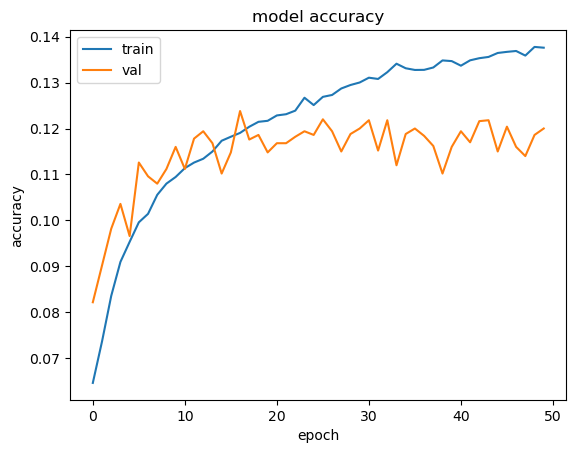

In [36]:
from matplotlib import pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left') 


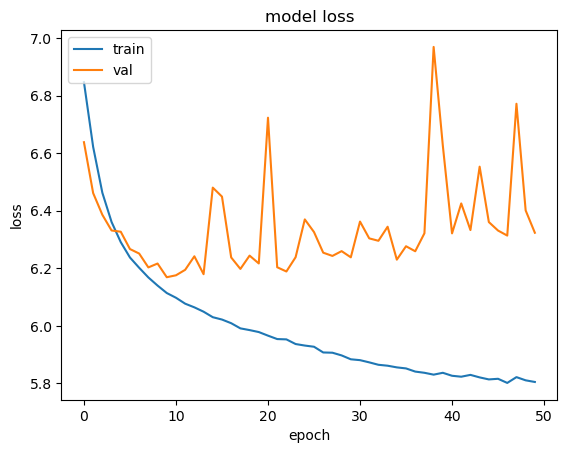

In [37]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')